# **DPRL - Assignment Week 1**

Expected Maximal Reward (V_1(5)): 32.36798015320855


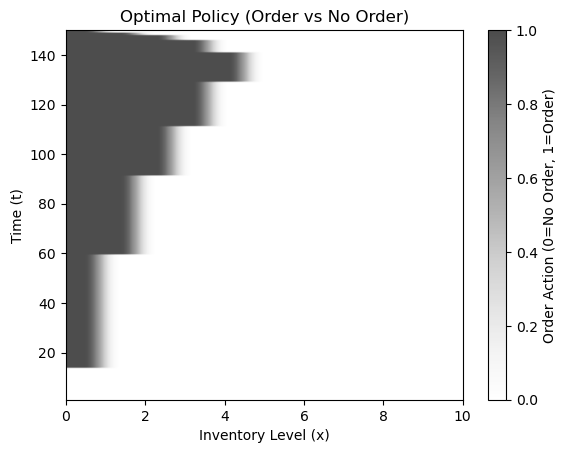

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Initialize Parameters ---
T = 150
X_MAX = 10  # Max inventory to consider (a guess, we can tune this)
x1 = 5

# --- 2. Initialize Tables ---
# We use T+2 so V[T+1] is our V_151 base case (all zeros)
V = np.zeros((T + 2, X_MAX + 1))
policy = np.zeros((T + 1, X_MAX + 1)) # T+1 because t=1..150

# --- 3. The Backward Induction Loop ---

# Create a vector for all possible states x = [0, 1, 2, ..., X_MAX]
x = np.arange(X_MAX + 1)

# Loop BACKWARD through time
for t in range(T, 0, -1):
    # Calculate demand probability for this time t
    p_t = (t - 1) / (T - 1)
    
    # --- A. Calculate E[Profit | a=0] (as a vector) ---
    
    # Revenue: min(x, 1)
    # We can use np.where or np.minimum. np.where is often clearer.
    # Revenue is 1 if x >= 1, else 0
    rev_a0 = np.where(x >= 1, 1, 0)
    
    # Next State: max(0, x-1)
    # We can't go below 0
    next_state_a0_d1 = np.maximum(0, x - 1)
    
    # E[Profit | a=0] = (1-p_t) * [0 + V[t+1, x]] + p_t * [rev_a0 + V[t+1, next_state_a0_d1]]
    val_a0 = (1 - p_t) * V[t + 1, x] + \
             p_t * (rev_a0 + V[t + 1, next_state_a0_d1])
             
    # --- B. Calculate E[Profit | a=1] (as a vector) ---
    
    # This is the "Order Fails" part, which is just val_a0
    val_a1_fails = val_a0 
    
    # This is the "Order Arrives" part
    # Revenue: min(x+1, 1) = 1 (since x >= 0, x+1 >= 1)
    rev_a1_arrives = 1 
    
    # Next State (Demand 0): x+1 (clip at X_MAX)
    next_state_a1_d0 = np.minimum(X_MAX, x + 1)
    
    # Next State (Demand 1): x
    next_state_a1_d1 = x
    
    # E[Profit | a=1 and Arrives]
    val_a1_arrives = (1 - p_t) * (0 + V[t + 1, next_state_a1_d0]) + \
                     p_t * (rev_a1_arrives + V[t + 1, next_state_a1_d1])
    
    # Total E[Profit | a=1]
    val_a1 = 0.5 * val_a1_fails + 0.5 * val_a1_arrives

    # --- C. Find the max and store it ---
    
    # This is the Bellman equation!
    # V[t, x] = -0.1*x + max(val_a0, val_a1)
    # We use np.maximum to get the element-wise max
    V[t, x] = -0.1 * x + np.maximum(val_a0, val_a1)
    
    # Store the policy that GAVE us that max
    # (val_a1 > val_a0) is a boolean array. .astype(int) turns (True, False) into (1, 0)
    policy[t, x] = (val_a1 > val_a0).astype(int)

# --- 4. Results ---
expected_max_reward = V[1, x1]
print(f"Expected Maximal Reward (V_1(5)): {expected_max_reward}")

# You can now plot the 'policy' array to answer Part B
plt.imshow(policy[1:], aspect='auto', origin='lower', 
           extent=[0, X_MAX, 1, T], cmap='Greys', alpha=0.7)
plt.colorbar(label='Order Action (0=No Order, 1=Order)')
plt.xlabel('Inventory Level (x)')
plt.ylabel('Time (t)')
plt.title('Optimal Policy (Order vs No Order)')
plt.savefig('optimal_policy.png', dpi=300)
plt.show()

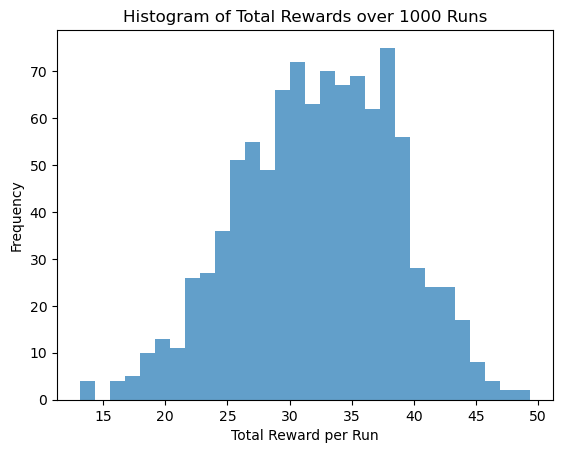

Mean Total Reward over 1000 Runs: 32.313100000000006


In [5]:
# Your policy table is the "agent"
policy_table = policy # This is the result from Part B

# This function IS your agent
def get_action(t, x, policy_table):
    # For DP, the agent is simple: just look up the answer.
    # In RL, this function would be much more complex.
    return policy_table[t, x]

# This function IS your environment
def step(t, current_x, action):
    # 1. Simulate Randomness
    p_t = (t - 1) / 149
    demand = 1 if np.random.rand() < p_t else 0
    
    arrival = 0
    if action == 1:
        arrival = 1 if np.random.rand() < 0.5 else 0
        
    # 2. Calculate Reward
    holding_cost = -0.1 * current_x
    inventory_available = current_x + arrival
    sales = min(inventory_available, demand)
    reward = holding_cost + (sales * 1)
    
    # 3. Calculate Next State
    next_x = max(0, inventory_available - demand)
    
    return next_x, reward

# --- 4. The Main Simulation Loop ---
all_run_rewards = []

for i in range(1000): # 1000 simulations
    current_x = 5    # Reset the state
    total_reward_for_this_run = 0
    
    for t in range(1, 151): # 150 time steps
        # 1. Agent gets action
        action_to_take = get_action(t, current_x, policy_table)
        
        # 2. Environment gives next state and reward
        next_x, reward = step(t, current_x, action_to_take)
        
        # 3. Accumulate reward and update state
        total_reward_for_this_run += reward
        current_x = next_x
        
    all_run_rewards.append(total_reward_for_this_run)

# 5. Report Results
# Now, all_run_rewards is a list of 1000 numbers.
# You can plot its histogram and calculate its mean.
plt.hist(all_run_rewards, bins=30, alpha=0.7)
plt.xlabel('Total Reward per Run')
plt.ylabel('Frequency')
plt.title('Histogram of Total Rewards over 1000 Runs')
plt.savefig('reward_histogram.png', dpi=300)
plt.show()
mean_reward = np.mean(all_run_rewards)
print(f"Mean Total Reward over 1000 Runs: {mean_reward}")